In this tutorial we will use robust algorithms to find spheres in a 3D scene. At the begining we'll generate a noisy point cloud with spheres.
First import the neccessary Python modules.


*   numpy - for arrays and matrix operations
*   random - for pseudo random numbers



In [1]:
import numpy as np
from random import random, seed
from math import sin, cos, pi, sqrt
from time import time

Random number is initialized by actual time in seconds. If you enter a constant instead of int(time), you can use the very same points every time.

In [2]:
np.random.seed(int(time()))

Let's generate random center points and radii for spheres.

In [3]:
x_range, y_range, z_range = 10, 20, 4   # working in a 10 x 20 x 4 mtres box
n = 10                                  # number of spheres to generate
min_r = 0.2                             # minimum radius
max_r = 0.6                             # maximum radius
xc = np.random.rand(n) * x_range
yc = np.random.rand(n) * y_range
zc = np.random.rand(n) * z_range
r = np.round(min_r + np.random.rand(n) * (max_r - min_r), decimals=2)

Let's generate random points with noise on the surface of the spheres.

In [4]:
points_per_sphere = 100
max_noise =  0.02
x = np.zeros((n + 1) * points_per_sphere)
y = np.zeros((n + 1) * points_per_sphere)
z = np.zeros((n + 1) * points_per_sphere)
for i in range(n):
  for j in range(points_per_sphere):
    alpha = random() * pi * 2
    beta = random() * pi - pi / 2
    ind = i * points_per_sphere + j
    x[ind] = xc[i] + r[i] * cos(beta) * cos(alpha)
    y[ind] = yc[i] + r[i] * cos(beta) * sin(alpha)
    z[ind] = zc[i] + r[i] * sin(beta)
# extra random points
x[n*points_per_sphere: (n+1)*points_per_sphere] = np.random.rand(points_per_sphere) * x_range
y[n*points_per_sphere: (n+1)*points_per_sphere] = np.random.rand(points_per_sphere) * y_range
z[n*points_per_sphere: (n+1)*points_per_sphere] = np.random.rand(points_per_sphere) * z_range
# random noise to all points
x += np.random.rand((n+1)*points_per_sphere) * max_noise
y += np.random.rand((n+1)*points_per_sphere) * max_noise

Let's check visually our point cloud using open3d.

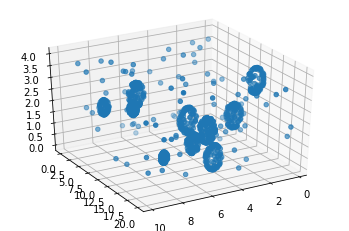

In [5]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
ax.view_init(32, 60)              # change the two view directions (in degree)

Let's create a function to find the best fitting sphere using four or more points.

In [ ]:
def sphere(x_, y_, z_):
  n_ = x_.shape[0]
  a = np.c_[x_, y_, z_, np.full(n_, 1, 'float64')]
  b = -np.square(x_) - np.square(y_) - np.square(z_)
  res = np.linalg.lstsq(a, b, rcond=None)[0]
  return -0.5 * res[0], -0.5 * res[1], -0.5 * res[2], \
          sqrt((res[0]**2 + res[1]**2 + res[2]**2) / 4 - res[3])


First try to make the necessary steps for the RANSAC algorithm. Let's select four random points for RANSAC.

In [6]:
def rand_pnts(x_, y_, z_, n_=4):
  """ select n_ points """
  m = x_.shape[0] # number of items
  l = list(set(np.random.randint(m, size=n_))) # remove repeated random integers
  while len(l) != n_:
    l = list(set(np.random.randint(m, size=n_)))
  return (x_[l], y_[l], z_[l])

Let's create a function to calculate the distances from the surface of a sphere to all points.

In [7]:
def ransac_dist(x_, y_, z_, sph_):
    """ calculate distance from the surface of sphere
        and returns the distances
    """
    d_ = np.abs(np.sqrt(np.square(x_ - sph_[0]) + np.square(y_ - sph_[1]) + np.square(z_ - sph_[2])) - sph_[3])
    return d_

Now we start the RANSAC algorithm. We will try to find the spheres one by one. Remove the points of the found sphere before searching for the next one.

In [8]:
tol = 0.02      # distance tolerance from the surface of sphere
max_iter = n * points_per_sphere * 4
x1 = np.copy(x) # preserve original coordinates
y1 = np.copy(y)
z1 = np.copy(z)
spheres = []    # for found spheres

We will repeat the search until enough points left or no more sphere found.

In [ ]:
while x1.shape[0] > points_per_sphere // 2:
    best_n = 0
    for i in range(max_iter):
        x4, y4, z4 = rand_pnts(x1, y1, z1)  # four random points
        x0, y0, z0, r0 = sphere(x4, y4, z4)
        d4 = ransac_dist(x1, y1, z1, np.array([x0, y0, z0, r0]))
        on4 = d4 < tol
        act_n = d4[on4].shape[0]
        if act_n > best_n and min_r <= r0 <= max_r:
            best_n = act_n
            best_on = np.copy(on4)
            best_x0, best_y0, best_z0, best_r0 = x0, y0, z0, r0
    if best_n > points_per_sphere // 2:
        spheres.append([best_x0, best_y0, best_z0, best_r0, best_n])
        x1 = x1[np.invert(best_on)]     # remove used points
        y1 = y1[np.invert(best_on)]
        z1 = z1[np.invert(best_on)]
    else:
        break

Finally let's write out the parameters of the found and the original spheres.

In [ ]:
print("Found spheres")
print("   x0       y0       z0       r        n")
for sph in spheres:
    print(f"{sph[0]:8.3f} {sph[1]:8.3f} {sph[2]:8.3f} {sph[3]:8.3f} {sph[4]:4d}")
print("Original spheres")
print("   x0       y0       z0       r        n")
for i in range(n):
    print(f"{xc[i]:8.3f} {yc[i]:8.3f} {zc[i]:8.3f} {r[i]:8.3f} {points_per_sphere:4d}")


Found spheres
   x0       y0       z0       r        n
   5.059   10.197    2.759    0.360  100
   3.629    5.610    0.036    0.324  100
   8.492    8.805    2.461    0.230  100
   9.810    2.452    2.462    0.317  100
   7.661   15.453    3.222    0.390  100
   0.584   19.609    2.895    0.389  100
   5.308    7.178    0.494    0.491  100
   3.080   15.769    2.726    0.439  100
   6.241   12.456    2.788    0.241  100
   3.884    2.427    0.370    0.390  100
Original spheres
   x0       y0       z0       r        n
   9.798    2.448    2.466    0.320  100
   6.223   12.441    2.791    0.240  100
   5.295    7.175    0.494    0.490  100
   8.489    8.795    2.461    0.230  100
   3.620    5.597    0.033    0.320  100
   3.872    2.422    0.370    0.390  100
   7.644   15.446    3.222    0.390  100
   5.051   10.186    2.763    0.360  100
   3.072   15.758    2.727    0.440  100
   0.573   19.594    2.899    0.390  100


**Tasks for practice**

*   Print out the number of inliers and outliers
*   Create a 3D plot having the spheres, inliers and outliers with different colors
*   Get more accurate positions of spheres using least squares estimation for all inliers. Get the statistics of residuals. How does the rms of residuals depend on the noise on the surface of the spheres?
*   Test the program on real data sets
*   Change the code to read data from text file
*   Change the code to use from the command line
*   Using Open3D and load files in different format

